<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [53]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [54]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

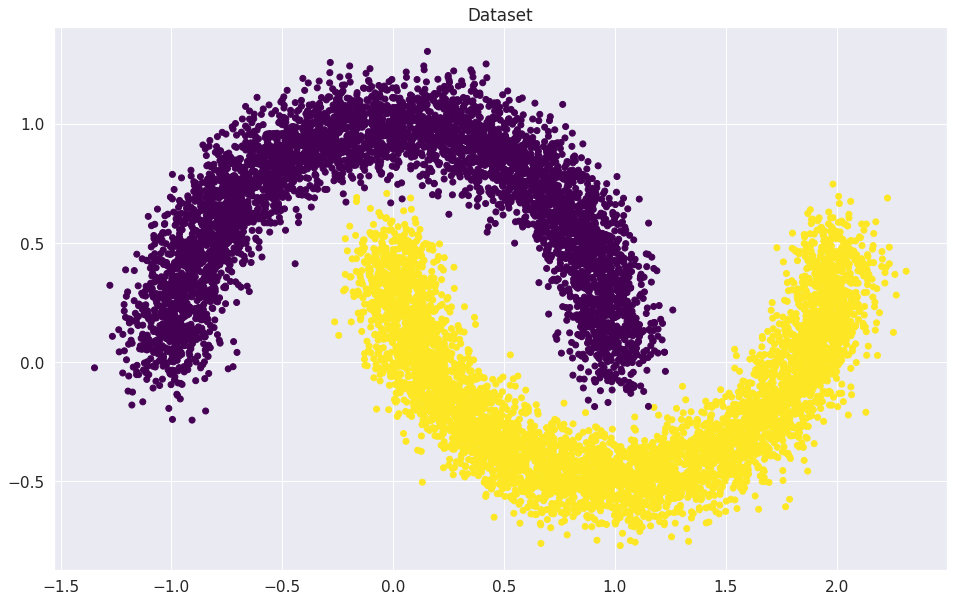

In [55]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()


Сделаем train/test split

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42) 

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [57]:
X_train_t = torch.FloatTensor(X_train)  # due to "torch.FloatTensor"
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)


Создаем `Dataset` и `DataLoader`. 

In [58]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)


## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [59]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(out_features, in_features)
        )  # changed the str - added in и out features
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))  # added Parameter

    def forward(self, x):
        x = x @ self.weights.t()
        if self.bias:
            x += self.bias
        return x


In [60]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?
**Ответ** 2


In [61]:
# due to linear_regression.parameters()
params = list(linear_regression.parameters())
len(params)


2

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [62]:
stroka = [1, 2, 3, 4]
stolb = [[1], [2], [3]]


np.reshape(stolb, -1)


array([1, 2, 3])

In [63]:
tol = 1e-3  # to see on list of probability
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):  # iteration in cycle
    for it, (X_batch, y_batch) in enumerate(train_dataloader):  # iteration in dataset
        optimizer.zero_grad()
        logits = linear_regression(X_batch).flatten()
        outp = torch.sigmoid(logits)  # Used sigmoid
        loss = loss_function(outp, y_batch)  # loss_function

        # >>> loss = nn.BCEWithLogitsLoss()
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(logits)  # added sigmoid

        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(
            torch.float32
        ).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(
                f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}"
            )
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(
                f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations."
            )
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break


Iteration: 0
Batch accuracy: 0.4765625
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.4609375
Iteration: 300
Batch accuracy: 0.578125
Iteration: 400
Batch accuracy: 0.4765625
Iteration: 500
Batch accuracy: 0.5078125
Iteration: 600
Batch accuracy: 0.4375
Iteration: 700
Batch accuracy: 0.5390625
Iteration: 800
Batch accuracy: 0.578125
Iteration: 900
Batch accuracy: 0.6328125
Iteration: 1000
Batch accuracy: 0.6953125
Iteration: 1100
Batch accuracy: 0.6015625
Iteration: 1200
Batch accuracy: 0.640625
Iteration: 1300
Batch accuracy: 0.5859375
Iteration: 1400
Batch accuracy: 0.7109375
Iteration: 1500
Batch accuracy: 0.6875
Iteration: 1600
Batch accuracy: 0.6640625
Iteration: 1700
Batch accuracy: 0.671875
Iteration: 1800
Batch accuracy: 0.8046875
Iteration: 1900
Batch accuracy: 0.7578125
Iteration: 2000
Batch accuracy: 0.734375
Iteration: 2100
Batch accuracy: 0.8046875
Iteration: 2200
Batch accuracy: 0.796875
Iteration: 2300
Batch accuracy: 0.75
Iteration: 2400
Batch 

In [64]:
y_batch  # I need to look at this, don't be surprised :)


tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 1.])

In [65]:
outp  # I need to look at this, don't be surprised :)

tensor([0.9793, 0.2233, 0.9446, 0.1559, 0.9950, 0.9548, 0.1568, 0.1909, 0.9063,
        0.2211, 0.9924, 0.9599, 0.9905, 0.9900, 0.9937, 0.6965, 0.5767, 0.8734,
        0.2370, 0.9930, 0.7569, 0.5101, 0.8962, 0.7252, 0.9919, 0.9947, 0.9967,
        0.9869, 0.1110, 0.7659, 0.9684, 0.9843, 0.9953, 0.1204, 0.1408, 0.8937,
        0.2380, 0.7363, 0.9835, 0.9931, 0.9676, 0.9959, 0.9959, 0.9555, 0.6215,
        0.9227, 0.9927, 0.9893, 0.5459, 0.8868, 0.2255, 0.9452, 0.8418, 0.9572,
        0.9974, 0.9812, 0.9284, 0.5195, 0.9956, 0.1921, 0.9927, 0.9419, 0.9416,
        0.9932, 0.8908, 0.9918, 0.1485, 0.0977, 0.9961, 0.9965, 0.3777, 0.9439,
        0.9975, 0.9912, 0.9941, 0.9518, 0.9798, 0.9949, 0.3242, 0.9924, 0.1299,
        0.1697, 0.1889, 0.9687, 0.8199, 0.1504, 0.8195, 0.9954, 0.9954, 0.9931,
        0.2010, 0.8446, 0.1344, 0.9892, 0.8296, 0.2452, 0.9464, 0.6835, 0.8435,
        0.9552, 0.9835, 0.8554, 0.9953, 0.7425, 0.5779, 0.9794, 0.9940, 0.9598,
        0.1543, 0.1768, 0.6496, 0.5033, 

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: 856**

### Визуализируем результаты

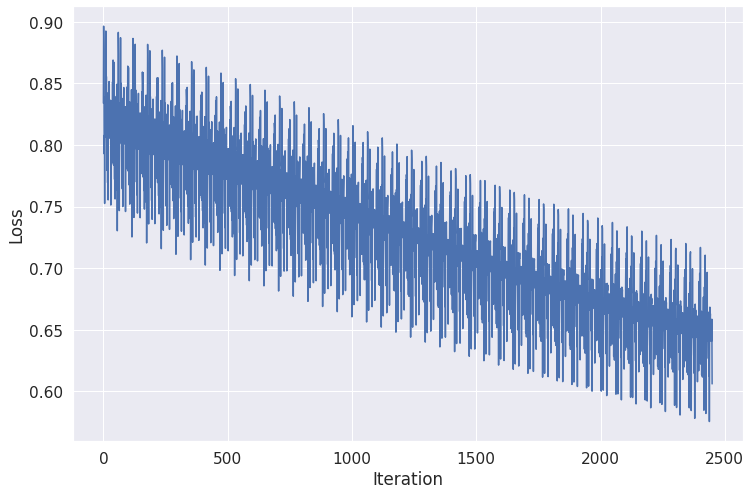

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


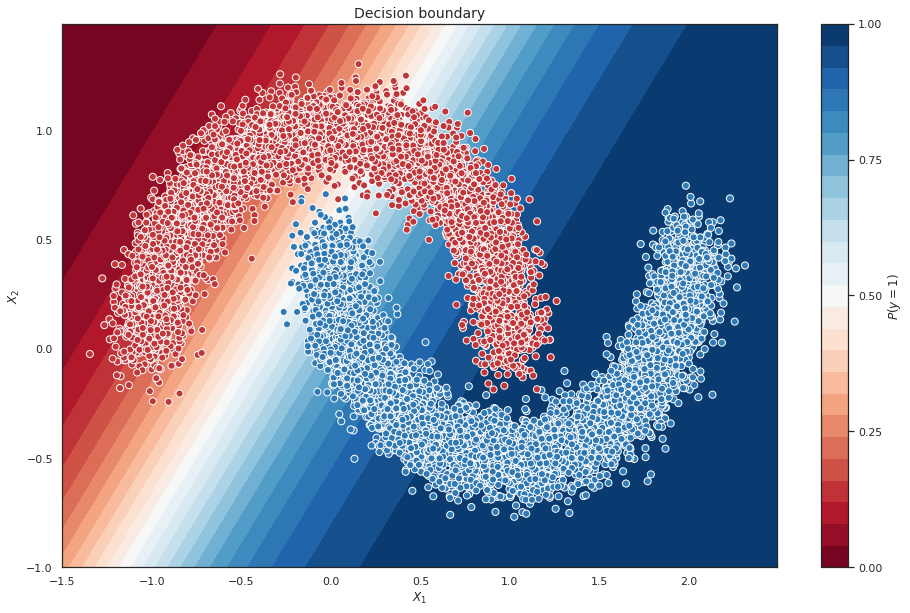

In [67]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:0.01, -1.0:1.5:0.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

ax.scatter(
    X[100:, 0],
    X[100:, 1],
    c=y[100:],
    s=50,
    cmap="RdBu",
    vmin=-0.2,
    vmax=1.2,
    edgecolor="white",
    linewidth=1,
)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()


### Задание. Реализуйте predict и посчитайте accuracy на test.

In [68]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:

        preds = preds = torch.argmax(
            x_batch @ W, dim=1
        )  # YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()


In [69]:
from sklearn.metrics import accuracy_score

# Computed total accuracy
acc = 0
acc += (preds == y_batch).cpu().numpy().mean()

acc


0.8203125

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: accuracy = 0.8515625** 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [70]:
from torchvision import (
    transforms as tfs,
)  # imported transforms as tfs, otherwise - error
from torchsummary import summary
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5), (0.5))])

# install for train and test
root = "./"
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2
)  # due to DataLoader
valid_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=2
)  # due to DataLoader


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [71]:
class Identical(nn.Module):
    def forward(self, x):
        return x


### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [72]:
def kotik(activation=nn.ELU):
    D_in, H, D_out = 28 * 28, 128, 10  # added
    model = nn.Sequential(
        nn.Flatten(),
        # added layers to my sequential class:
        torch.nn.Linear(D_in, H),
        # D_in - размерность входа (количество признаков у объекта);
        # H - размерность скрытых слоёв;
        # D_out - размерность выходного слоя (суть - количество классов)
        activation(),
        torch.nn.Linear(H, H),
        activation(),
        torch.nn.Linear(H, D_out),
        torch.nn.Softmax(),
    )

    return model


In [73]:
criterion = nn.CrossEntropyLoss()  # selected a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [75]:
net = Identical()
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                # X_batch, y_batch = batch
                optimizer.zero_grad()

                outp = model(x_batch.to(device))
                loss = criterion(outp.to(device), y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))

            preds = outp.argmax(-1)
            correct = (preds.cpu().detach() == y_batch).sum()  # YOUR CODE GOES HERE
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #     loss.backward()
            #     optimizer.step()
            # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9585666666666667
Loader: valid. Accuracy: 0.9775
Epoch: 2
Loader: train. Accuracy: 0.98295
Loader: valid. Accuracy: 0.9835
Epoch: 3
Loader: train. Accuracy: 0.987
Loader: valid. Accuracy: 0.986
Epoch: 4
Loader: train. Accuracy: 0.9890833333333333
Loader: valid. Accuracy: 0.9888


In [76]:
x_batch.shape

torch.Size([4, 1, 28, 28])

In [77]:
y_batch

tensor([3, 4, 5, 6])

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [78]:
elu_accuracy = accuracy["valid"]

In [94]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)


def test_activation_function(activation):
    model = kotik(activation)
    criterion = nn.CrossEntropyLoss()  # selected a loss function
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10  # to brief overview result
    accuracy = {"train": [], "valid": []}
    model.to(device)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    # X_batch, y_batch = batch
                    optimizer.zero_grad()

                    outp = model(x_batch.to(device))
                    loss = criterion(outp.to(device), y_batch.to(device))
                    loss.backward()
                    optimizer.step()
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))

                preds = outp.argmax(-1)
                correct = (preds.cpu().detach() == y_batch).sum()  # YOUR CODE GOES HERE
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                # if k == "train":
                #     loss = criterion(outp, y_batch)
                #     loss.backward()
                #     optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)
    return accuracy["valid"]


In [95]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(torch.nn.ReLU)
leaky_relu_accuracy = test_activation_function(torch.nn.LeakyReLU)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.6047333333333333
Loader: valid. Accuracy: 0.6689
Epoch: 2
Loader: train. Accuracy: 0.60915
Loader: valid. Accuracy: 0.6719
Epoch: 3
Loader: train. Accuracy: 0.5351666666666667
Loader: valid. Accuracy: 0.6271
Epoch: 4
Loader: train. Accuracy: 0.5936833333333333
Loader: valid. Accuracy: 0.6322
Epoch: 1
Loader: train. Accuracy: 0.84605
Loader: valid. Accuracy: 0.8646
Epoch: 2
Loader: train. Accuracy: 0.88585
Loader: valid. Accuracy: 0.8994


KeyboardInterrupt: ignored

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

**Работает качественно, это один из выбросов. Можете запустить, проверить.**

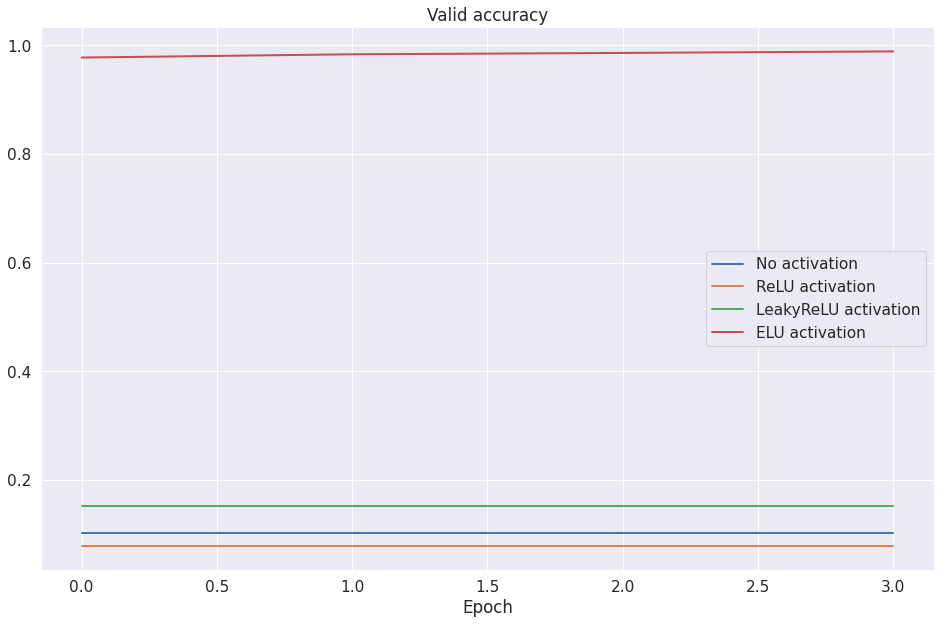

In [81]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


**Работает качественно, это один из выбросов. Можете запустить, проверить.**

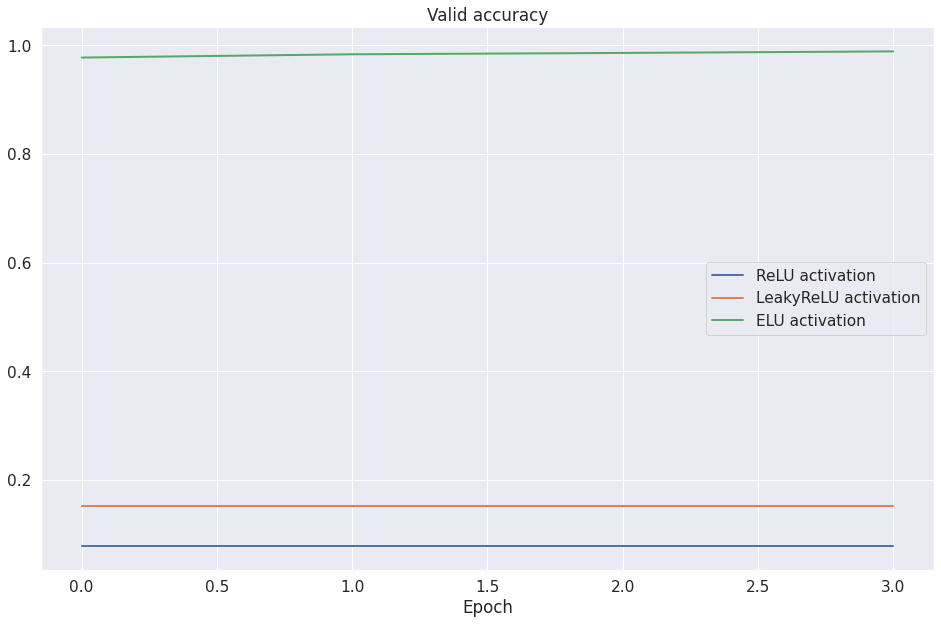

In [82]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [83]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-12-06 20:09:25--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-12-06 20:09:25--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   219KB/s    in 0.2s    

2021-12-06 20:09:26 (219 KB/s) - ‘sample_photo.jpg’ saved [49337/4

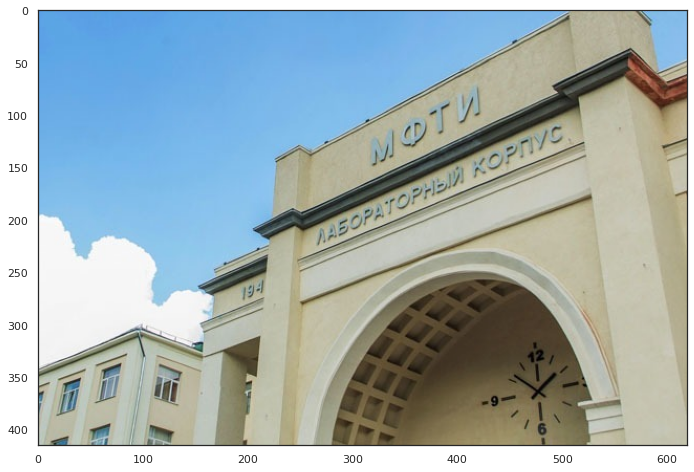

In [84]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()


Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [85]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = (
    torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    .reshape(1, 1, 3, 3)
    .type(torch.float32)
)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


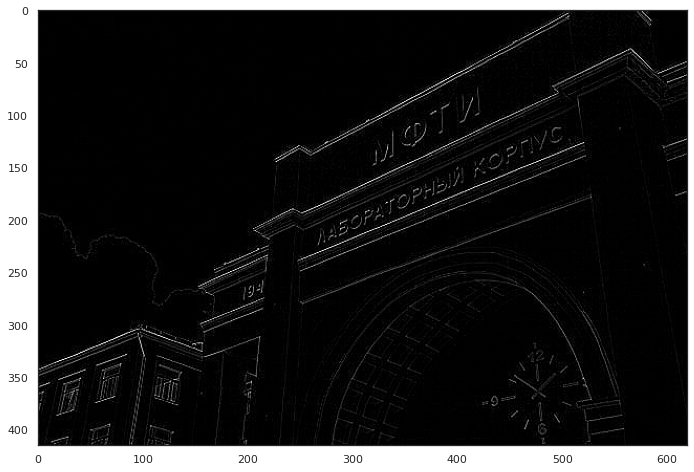

In [86]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()


**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А-3),  Б-4),  В-5),  Г-6),  Д-2),  Е-1)

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [87]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = #YOUR CODE. Apply layers created in __init__.
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [88]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [98]:
model = LeNet()
max_epochs = 10
criterion = nn.CrossEntropyLoss()  # selected a loss function
optimizer = torch.optim.Adam(model.parameters())
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                # X_batch, y_batch = batch
                optimizer.zero_grad()

                outp = model(x_batch.to(device))
                loss = criterion(outp.to(device), y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))

            preds = outp.argmax(-1)
            correct = (preds.cpu().detach() == y_batch).sum()  # YOUR CODE GOES HERE
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
            #     loss = criterion(outp, y_batch)
            #     loss.backward()
            #     optimizer.step()
            # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9582833333333334
Loader: valid. Accuracy: 0.9823


In [90]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

**Работает качественно, это один из выбросов. Можете запустить, проверить.**

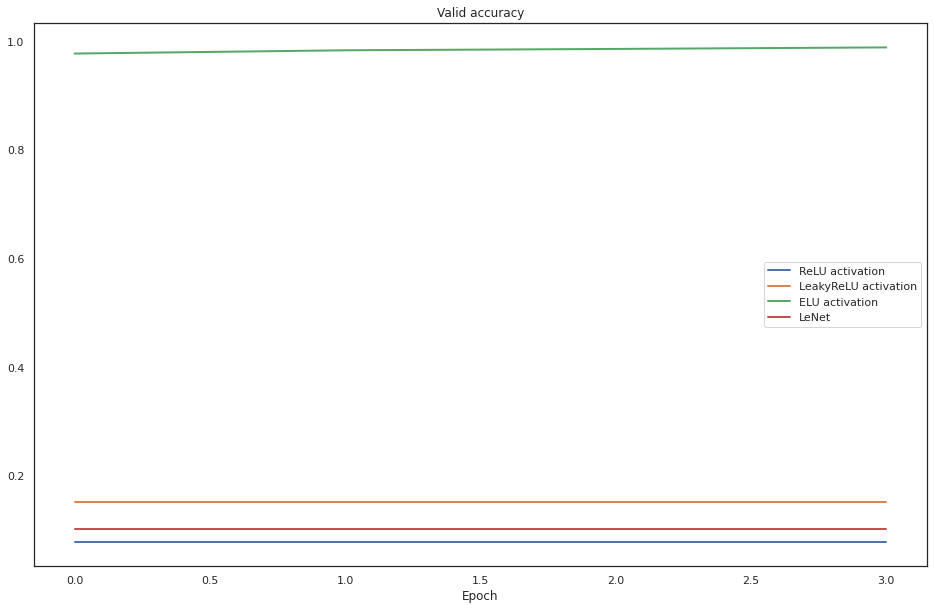

In [91]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(
    range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2
)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98